# Generate samples for a single scene

In [9]:
import sys
import os
import pylab as plt
import numpy as np
from matplotlib.colors import ListedColormap
from osgeo import gdal
from importlib import reload

sys.path.insert(0, '../src')
import datasetGen.rasterizer as rstzr
import datasetGen.sampleGenerator as sg
import utils.filesystem as fs

reload(rstzr)
reload(sg)
reload(fs)

%matplotlib inline

In [14]:
# Input Files
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real')
shape_file = os.path.join(DATA_DIR, 'PRODES2016_225-64_REP.shp')
raster_file = os.path.join(DATA_DIR, "Landsat8_225-64_17-07-2016-B1-7.tif")
class_column = "agregClass"

# Output Files
output_path = os.path.join(DATA_DIR, 'generated')
fs.mkdir(output_path)
output_shp = os.path.join(output_path, "samples.shp")
out_shp_layer = "samples"

number_of_samples = 5000
window_size = 21

## Rasterize the input shape file

In [15]:
rasterizer = rstzr.Rasterizer(shape_file, raster_file, class_column)
rasterizer.collect_class_names()
rasterizer.rasterize_layer()
class_names = rasterizer.get_class_names()
rasterized_layer = rasterizer.get_labeled_raster()

Raster Shape: (7741, 7591)


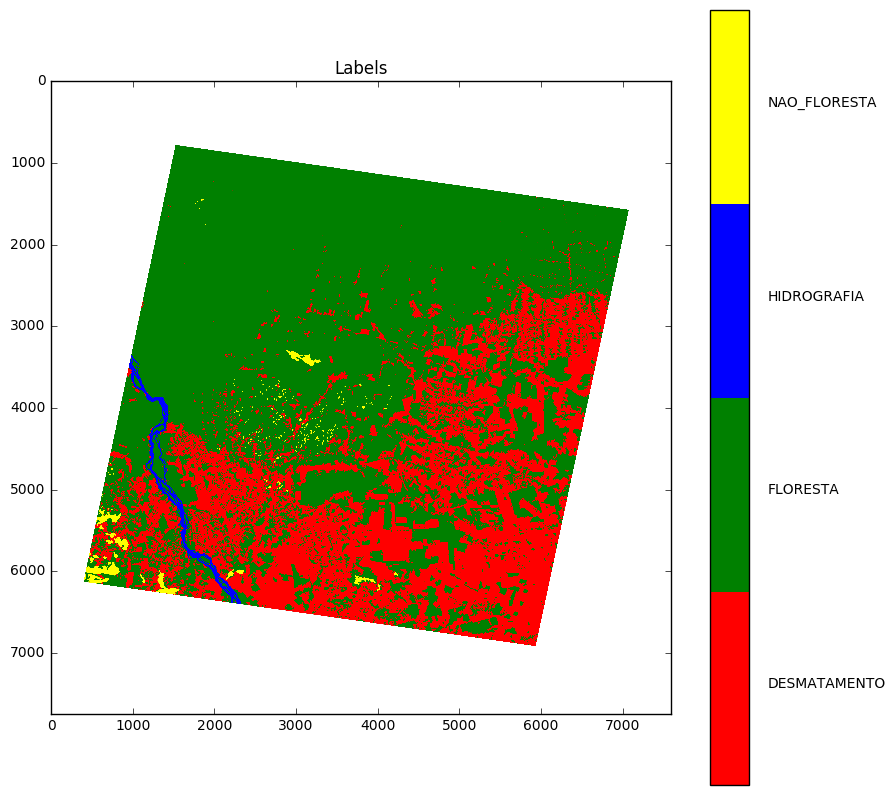

In [16]:
plt.figure(figsize=(10, 10))
plt.title('Labels')
print("Raster Shape:", rasterized_layer.shape)
labels = np.ma.masked_where(rasterized_layer == 255, rasterized_layer)

colorMap = ListedColormap(["red", "green", "blue", "yellow"])
plt.imshow(rasterized_layer, cmap=colorMap)
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(class_names):
    cbar.ax.text(1.5, (2 * j + 1) / 8, lab, ha='left')

cbar.ax.get_yaxis().labelpad = 15

In [18]:
raster_ds = gdal.Open(raster_file)
raster_img = raster_ds.ReadAsArray()
raster_img = np.rollaxis(raster_img, 0, start=3)
smpGen = sg.SampleGenerator(raster_img, rasterized_layer, class_names, raster_file)
smpGen.compute_sample_indexes(number_of_samples)
smpGen.extract_windows(window_size)
smpGen.generate_windows_geo_coords()
smpGen.save_samples_SHP(output_shp, out_shp_layer)

[-685635.0, -686265.0, 337155.0, 336525.0]
{'lowerLin': 5416, 'upperLin': 5395, 'rightCol': 1678, 'leftCol': 1699}


In [ ]:
#TODO: Plot here the shape file over the raster. Review the whole class.
# - Remove layer_name parameter.
# - Create execute method. 
# - Implement method to save to geotiff. In this method, allow the user to pass a list of indexes to save (none saves everything)